In [5]:
import sys, os
sys.path.append('/user_data/mmhender/imStat/code/')
from utils import default_paths, prf_utils, nsd_utils
from model_fitting import initialize_fitting
import h5py
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats


In [6]:
from scipy.io import loadmat
cluster_fn = os.path.join('/user_data/mmhender/toolboxes/SketchTokens/', 'clusters.mat')
clust = loadmat(cluster_fn)
feature_ims = clust['clusters']['clusters'][0][0]

dfname = '/user_data/mmhender/features/sketch_tokens/cluster_ims_curv_rect_values.csv'
df = pd.read_csv(dfname)
curv_values = np.array(df['best_bend'])
orient_values =np.array(df['best_orient'])*180/np.pi
df

,files,best_scale,best_bend,best_orient
0,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,1.658063
1,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,3.141593
2,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,1.308997
3,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,4.625123
4,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,0.349066
...,...,...,...,...
145,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,3.141593
146,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0025,4.712389
147,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0025,1.745329
148,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,4.712389


In [3]:
np.argmax(curv_values[0:106])

49

number of pRFs: 1456
most extreme RF positions:
[2.7755576e-17 0.0000000e+00 2.0000000e-02]
[ 0.7698996  -0.31890285  1.        ]


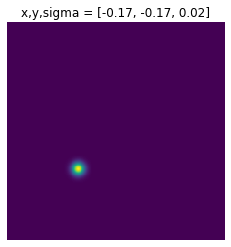

In [65]:
which_prf_grid=5

_, models = initialize_fitting.get_prf_models(aperture_rf_range=1.1, which_grid=which_prf_grid)

# mm=200
# mm = 600
# mm = 518
mm = 90

x,y,sigma = models[mm,:]
n_pix = 240
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=n_pix)

plt.figure();
plt.pcolormesh(prf_2d)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.title('x,y,sigma = [%.2f, %.2f, %.2f]'%(x,y,sigma));

In [66]:
subject=1
st_features_file = os.path.join(default_paths.sketch_token_feat_path, \
                                'S%d_features_each_prf_grid%d.h5py'%(subject, which_prf_grid))
print('loading from %s'%st_features_file)
t = time.time()
with h5py.File(st_features_file, 'r') as data_set:
    values = np.copy(data_set['/features'][:,:,mm])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)
print(values.shape)

features_in_prf = values

loading from /user_data/mmhender/features/sketch_tokens/S1_features_each_prf_grid5.h5py
Took 3.06794 seconds to load file
(10000, 151)


In [67]:
image_data = nsd_utils.get_image_data(subject)
image_data = nsd_utils.image_uncolorize_fn(image_data)


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


Text(0.5, 0.98, 'feature 20, curv=0.0025, orient=59')

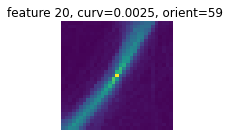

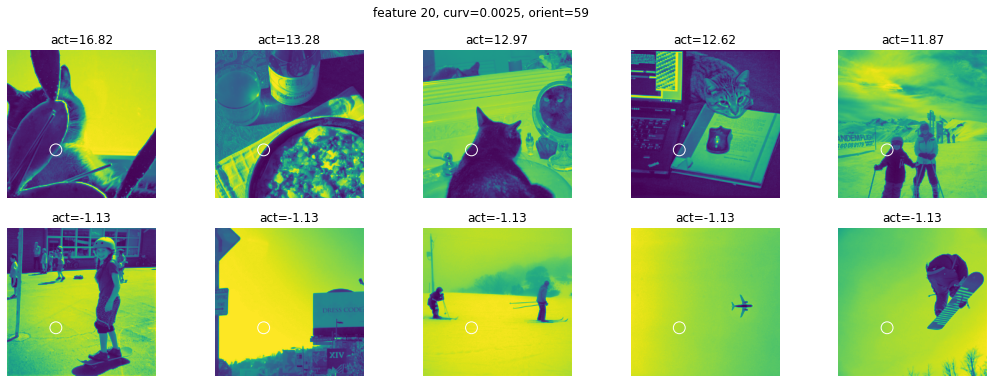

In [69]:
ff = 20
zvals = scipy.stats.zscore(features_in_prf[:,ff])

plt.figure(figsize=(2,2));
plt.pcolormesh(feature_ims[:,:,ff].T)
plt.gca().invert_yaxis()
plt.axis('off')
# plt.axis('square')
plt.suptitle('feature %d, curv=%.4f, orient=%d'%(ff, curv_values[ff], orient_values[ff]))

top_n = 5
top_images = np.flip(np.argsort(zvals))[0:top_n]
bottom_images = np.argsort(zvals)[0:top_n]
top_resp = zvals[top_images]
bottom_resp = zvals[bottom_images]
top_images = image_data[top_images,0,:,:]
bottom_images = image_data[bottom_images,0,:,:]

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(18,6));
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1);
    plt.imshow(top_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('act=%.2f'%top_resp[ii])
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1+top_n);    
    plt.imshow(bottom_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('act=%.2f'%bottom_resp[ii])
    
plt.suptitle('feature %d, curv=%.4f, orient=%d'%(ff, curv_values[ff], orient_values[ff]))

Text(0.5, 0.98, 'feature 0, curv=0.0000, orient=95')

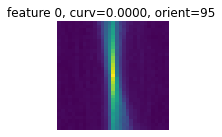

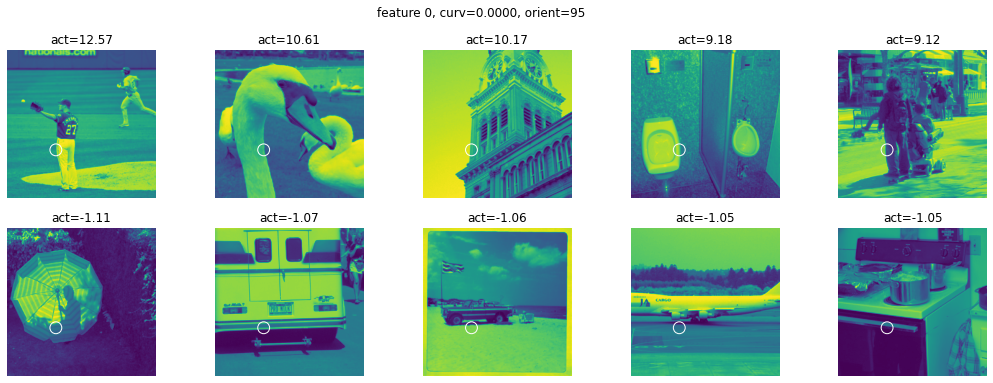

In [70]:
ff = 0
zvals = scipy.stats.zscore(features_in_prf[:,ff])

plt.figure(figsize=(2,2));
plt.pcolormesh(feature_ims[:,:,ff].T)
plt.gca().invert_yaxis()
plt.axis('off')
# plt.axis('square')
plt.suptitle('feature %d, curv=%.4f, orient=%d'%(ff, curv_values[ff], orient_values[ff]))

top_n = 5
top_images = np.flip(np.argsort(zvals))[0:top_n]
bottom_images = np.argsort(zvals)[0:top_n]
top_resp = zvals[top_images]
bottom_resp = zvals[bottom_images]
top_images = image_data[top_images,0,:,:]
bottom_images = image_data[bottom_images,0,:,:]

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(18,6));
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1);
    plt.imshow(top_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('act=%.2f'%top_resp[ii])
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1+top_n);    
    plt.imshow(bottom_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('act=%.2f'%bottom_resp[ii])
    
plt.suptitle('feature %d, curv=%.4f, orient=%d'%(ff, curv_values[ff], orient_values[ff]))

Text(0.5, 0.98, 'feature 49, curv=0.0125, orient=220')

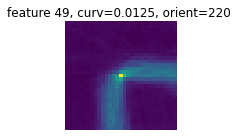

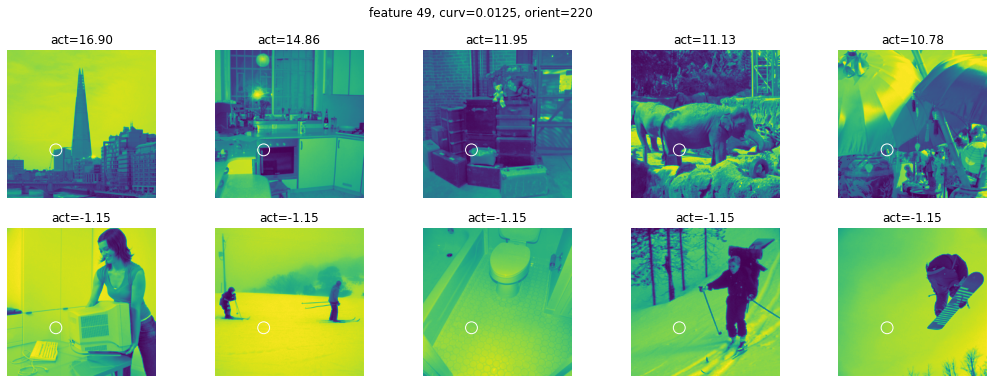

In [71]:
ff = 49
zvals = scipy.stats.zscore(features_in_prf[:,ff])

plt.figure(figsize=(2,2));
plt.pcolormesh(feature_ims[:,:,ff].T)
plt.gca().invert_yaxis()
plt.axis('off')
# plt.axis('square')
plt.suptitle('feature %d, curv=%.4f, orient=%d'%(ff, curv_values[ff], orient_values[ff]))

top_n = 5
top_images = np.flip(np.argsort(zvals))[0:top_n]
bottom_images = np.argsort(zvals)[0:top_n]
top_resp = zvals[top_images]
bottom_resp = zvals[bottom_images]
top_images = image_data[top_images,0,:,:]
bottom_images = image_data[bottom_images,0,:,:]

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(18,6));
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1);
    plt.imshow(top_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('act=%.2f'%top_resp[ii])
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1+top_n);    
    plt.imshow(bottom_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('act=%.2f'%bottom_resp[ii])
    
plt.suptitle('feature %d, curv=%.4f, orient=%d'%(ff, curv_values[ff], orient_values[ff]))

Text(0.5, 0.98, 'feature 107, curv=0.0563, orient=25')

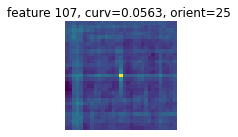

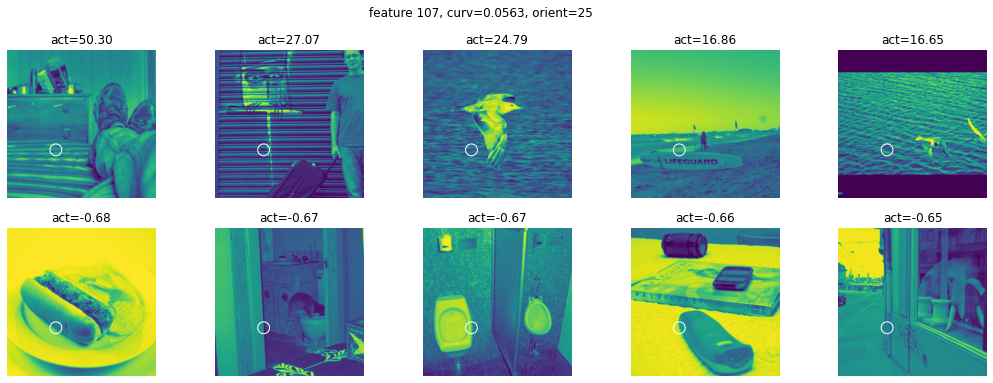

In [72]:
ff = 107
zvals = scipy.stats.zscore(features_in_prf[:,ff])

plt.figure(figsize=(2,2));
plt.pcolormesh(feature_ims[:,:,ff].T)
plt.gca().invert_yaxis()
plt.axis('off')
# plt.axis('square')
plt.suptitle('feature %d, curv=%.4f, orient=%d'%(ff, curv_values[ff], orient_values[ff]))

top_n = 5
top_images = np.flip(np.argsort(zvals))[0:top_n]
bottom_images = np.argsort(zvals)[0:top_n]
top_resp = zvals[top_images]
bottom_resp = zvals[bottom_images]
top_images = image_data[top_images,0,:,:]
bottom_images = image_data[bottom_images,0,:,:]

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(18,6));
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1);
    plt.imshow(top_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('act=%.2f'%top_resp[ii])
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1+top_n);    
    plt.imshow(bottom_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('act=%.2f'%bottom_resp[ii])
    
plt.suptitle('feature %d, curv=%.4f, orient=%d'%(ff, curv_values[ff], orient_values[ff]))

In [92]:
# Find an ordering for the sketch tokens features that captures bend/orient info
bend_each_feature = np.array(df['best_bend'])
orient_each_feature = np.array(df['best_orient']*180/np.pi)
bend_values = np.array([0, 0.02,0.07,0.10,0.18,0.45])/8
orients_rad = np.linspace(0,2*np.pi,73)[0:72]
orients_deg = orients_rad*180/np.pi
n_ori = len(np.unique(orients_deg))
n_bend = len(np.unique(bend_values))

sorder = np.argsort(bend_each_feature)
bends_sorted = bend_each_feature[sorder]
orients_sorted = orient_each_feature[sorder]

for bb in range(n_bend):
    inds = np.where(bends_sorted==bend_values[bb])[0]
    orients_to_sort = orients_sorted[inds]
    sorder_to_sort = sorder[inds]
    
    orient_sorder = np.argsort(orients_to_sort)
    orients_sorted[inds] = orients_to_sort[orient_sorder]
    sorder[inds] = sorder_to_sort[orient_sorder]
    
bends_sorted = bend_each_feature[sorder]
orients_sorted = orient_each_feature[sorder]

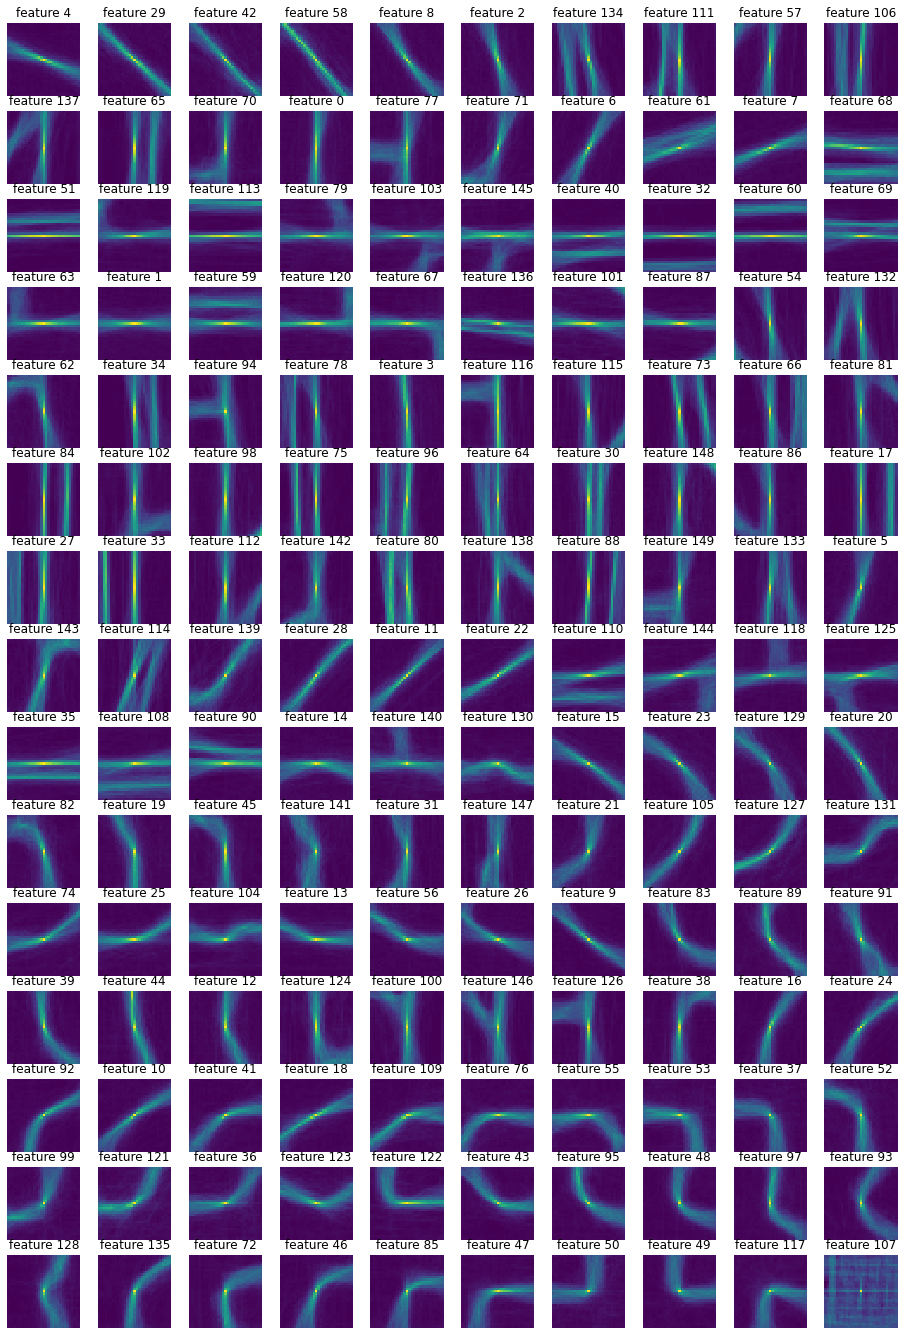

In [111]:
# plot the features in sorted order

plt.figure(figsize=(16,24));
for ii, ff in enumerate(sorder):
    plt.subplot(15,10, ii+1)
    plt.pcolormesh(feature_ims[:,:,ff].T)
    plt.axis('off')
    plt.axis('square')
    plt.title('feature %d'%ff)
#     plt.title('bend=%.4f, ori=%d'%(bend_each_feature[ff], orient_each_feature[ff]))
    

In [108]:
import copy
# thresh = 0.10
thresh = 0.08
feature_ims_adj = copy.deepcopy(feature_ims)
feature_ims_adj[feature_ims<thresh] = 0
# feature_ims_adj[feature_ims>thresh] = 1

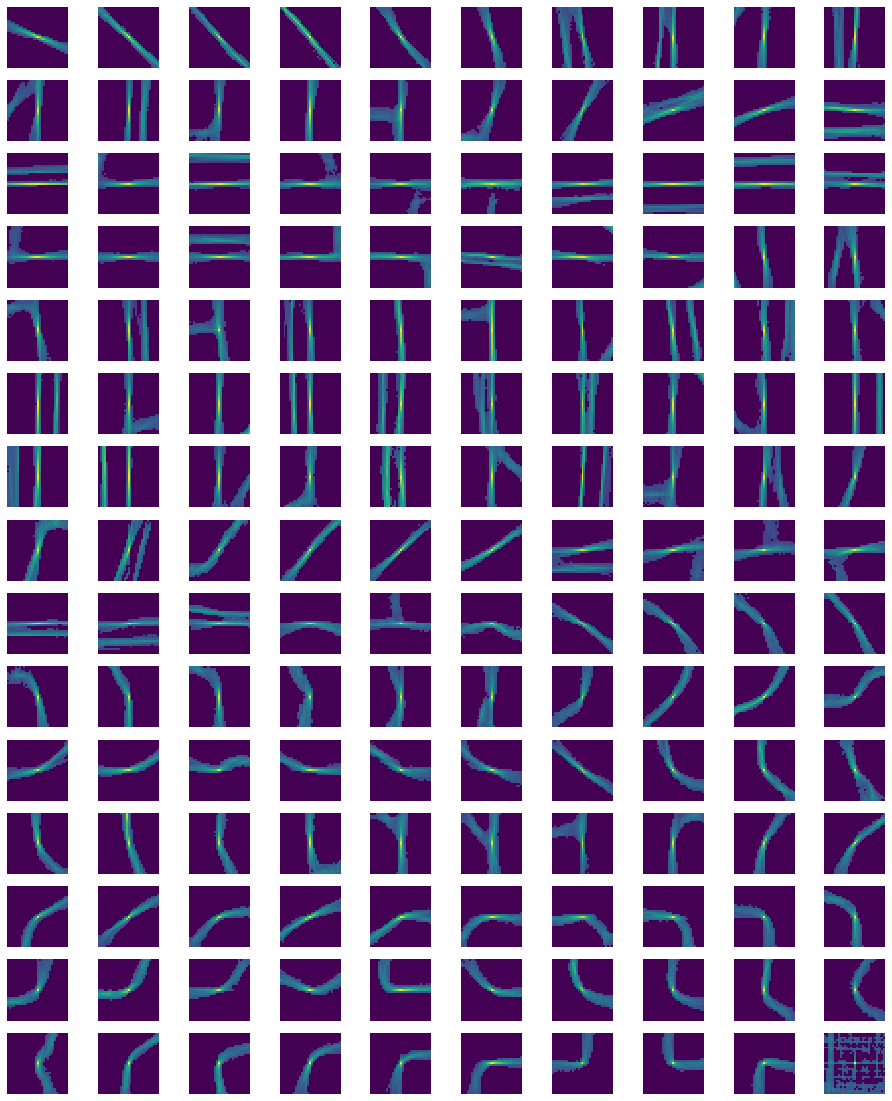

In [109]:
# plot the thresholded features in sorted order

plt.figure(figsize=(16,20));
for ii, ff in enumerate(sorder):
    plt.subplot(15,10, ii+1)
    plt.pcolormesh(feature_ims_adj[:,:,ff].T)
    plt.axis('off')
    plt.axis('square')
#     plt.title('bend=%.4f, ori=%d'%(bend_each_feature[ff], orient_each_feature[ff]))
    

In [76]:
fn2save = '/user_data/mmhender/imStat/model_fits/S01/sketch_tokens/Nov-11-2021_1659_27/all_fit_params'
out = torch.load(fn2save)
best_params = out['best_params']
params = best_params
best_models, weights, bias, features_mt, features_st, best_model_inds = params  

In [90]:
out['which_prf_grid']

5

[ 55 140 130  53  79]


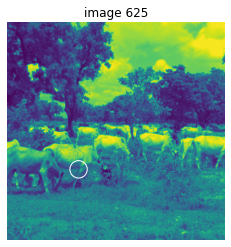

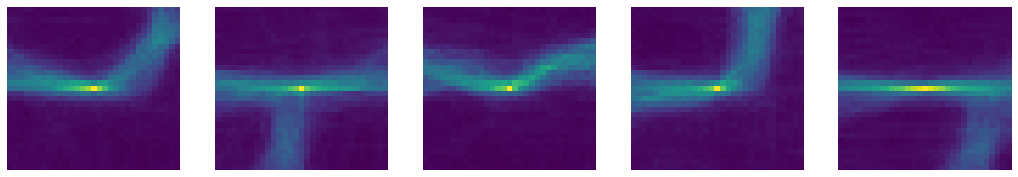

In [89]:
# For a given image patch, plot which ST features yielded highest response.

# z-scoring across images, so that we get the channels that were highest relative to their distribution.
# otherwise some channels are always top because higher mean activ.
# zvalues = scipy.stats.zscore(features_in_prf, axis=0)

n_trials = features_in_prf.shape[0]
tiled_mean = np.tile(features_mt[mm,:], [n_trials, 1])
tiled_std = np.tile(features_st[mm,:], [n_trials, 1])
zvalues = (features_in_prf[:,0:150] - tiled_mean)/tiled_std

ii = 625
# ii=665
features = zvalues[ii,0:150]
top_n=5
top_features = np.flip(np.argsort(features))[0:top_n]
print(top_features)

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure();
ax = plt.subplot(1,1,1)
plt.imshow(image_data[ii,0,:,:])
circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                             color = 'w', fill=False)
ax.add_artist(circ)
plt.axis('off')
plt.title('image %d'%ii)

plt.figure(figsize=(18,3));
for ii, ff in enumerate(top_features):
    
    plt.subplot(1,top_n, ii+1);
    plt.pcolormesh(feature_ims[:,:,ff].T)
    plt.gca().invert_yaxis()
    plt.axis('off')
    # plt.axis('square')
#     plt.suptitle('feature %d, curv=%.4f, orient=%d'%(ff, curv_values[ff], orient_values[ff]))


In [75]:
features_in_prf.shape

(10000, 151)

In [47]:
zvalues.shape

(151, 227, 227, 1)

In [11]:
# Load some raw sketch tokens feature maps
from utils import default_paths
sketch_token_feat_path = default_paths.sketch_token_feat_path_localnode
map_resolution = 227  
subject = 1
features_file = os.path.join(sketch_token_feat_path, 'S%d_features_%d.h5py'%(subject, map_resolution))

In [12]:
with h5py.File(features_file, 'r') as data_set:
    ds_size = data_set['/features'].shape
n_images = ds_size[3]
n_features = ds_size[0]
map_resolution = ds_size[1]
n_prfs = models.shape[0]

In [16]:
batch_inds = np.array([665])
print('Loading features for images [%d - %d]'%(batch_inds[0], batch_inds[-1]))
st = time.time()
with h5py.File(features_file, 'r') as data_set:
    # Note this order is reversed from how it was saved in matlab originally.
    # The dimensions go [features x h x w x images]
    # Luckily h and w are swapped matlab to python anyway, so can just switch the first and last.
    values = np.copy(data_set['/features'][:,:,:,batch_inds])
    data_set.close()  
fmaps_batch = np.moveaxis(values, [0,1,2,3],[3,1,2,0])

elapsed = time.time() - st
print('Took %.5f sec to load feature maps'%elapsed)


Loading features for images [665 - 665]
Took 5.59537 sec to load feature maps


In [18]:
fmaps_batch.shape

(1, 227, 227, 151)

In [55]:
from utils import torch_utils
import torch
aperture=1.0
device = 'cpu:0'
n_pix = map_resolution
# Define the RF for this "model" version
prf = torch_utils._to_torch(prf_utils.gauss_2d(center=[x,y], sd=sigma, \
                   patch_size=n_pix, aperture=aperture, dtype=np.float32), device=device)
minval = torch.min(prf)
maxval = torch.max(prf-minval)
prf_scaled = (prf - minval)/maxval

In [59]:

maps_full_field = torch_utils._to_torch(fmaps_batch, device=device)
maps = maps_full_field * prf_scaled.view([1,map_resolution,map_resolution,1])

In [32]:
maps.shape

torch.Size([1, 227, 227, 151])

(0.0, 227.0, 227.0, 0.0)

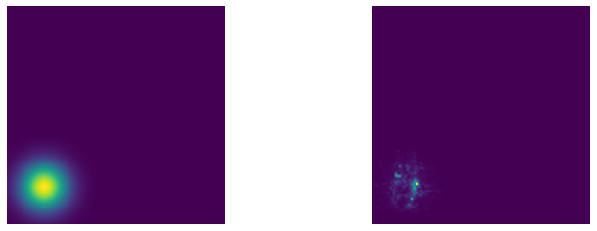

In [60]:
plt.figure(figsize=(12,4));

plt.subplot(1,2,1)
plt.pcolormesh(prf_scaled)
plt.axis('square')
plt.gca().invert_yaxis()
plt.axis('off')

plt.subplot(1,2,2)
plt.pcolormesh(torch_utils.get_value(maps[0,:,:,top_features[1]]))
plt.axis('square')
plt.gca().invert_yaxis()
plt.axis('off')

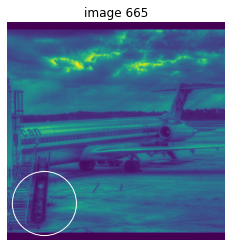

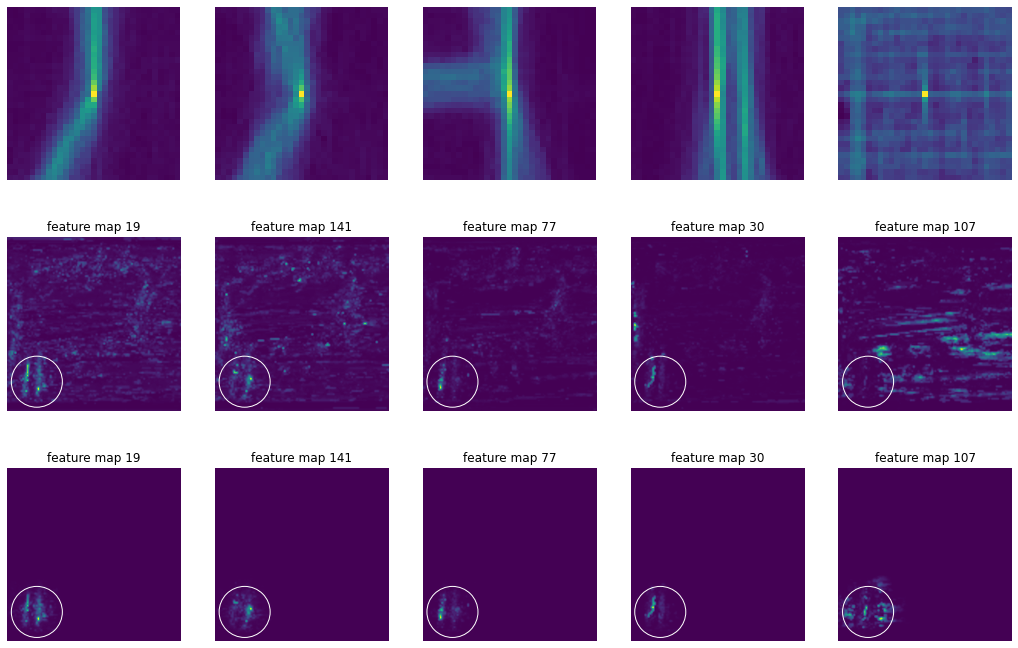

In [64]:
n_pix = image_data.shape[2]
center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

ii=665

plt.figure();
ax = plt.subplot(1,1,1)
plt.imshow(image_data[ii,0,:,:])
circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                             color = 'w', fill=False)
ax.add_artist(circ)
plt.axis('off')
plt.title('image %d'%ii)


n_pix = map_resolution
center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix


plt.figure(figsize=(18,12));
for ii, ff in enumerate(top_features):
    
    plt.subplot(3,top_n, ii+1);
    plt.pcolormesh(feature_ims[:,:,ff].T)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.axis('off')

for ii, ff in enumerate(top_features):
    ax = plt.subplot(3,top_n, ii+1+top_n);
    plt.imshow(fmaps_batch[0,:,:,ff])
#     plt.imshow(torch_utils.get_value(maps[0,:,:,ff]))
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('feature map %d'%ff)
#     plt.colorbar()
    
for ii, ff in enumerate(top_features):
    ax = plt.subplot(3,top_n, ii+1+2*top_n);
#     plt.imshow(fmaps_batch[0,:,:,ff])
    plt.imshow(torch_utils.get_value(maps[0,:,:,ff]))
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('feature map %d'%ff)
#     plt.colorbar()